In [9]:
from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_images = torch.tensor(train_images / 255, dtype=torch.float32)
test_images = torch.tensor(test_images / 255, dtype=torch.float32)

train_images = train_images.unsqueeze(1)
test_images = test_images.unsqueeze(1)

train_loader = DataLoader(train_images, batch_size=9192, shuffle=True)
test_loader = DataLoader(test_images, batch_size=9192, shuffle=False)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.linear1 = nn.Linear(64 * 3 * 3, latent_dim)
        self.linear2 = nn.Linear(64 * 3 * 3, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.linear1(x)
        logvar = self.linear2(x)
        return mu, logvar

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, 64 * 3 * 3)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, 5, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 64, 3, 3)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

In [13]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.latent_dim = latent_dim

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [21]:
vae = VAE(latent_dim=16).to('cuda')

In [22]:
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()

    def forward(self, x_hat, x, mu, logvar):
        recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_loss, recon_loss, kl_loss

In [23]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

def train(model, train_loader, epochs, lr, device):
    writer = SummaryWriter()
    model.to(device)
    criterion = VAELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=0.00001)
    prev_lr = lr
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, desc="Training", leave=False)
        for batch_idx, data in enumerate(train_bar):
            data = data.to(device)
            optimizer.zero_grad()
            x_hat, mu, logvar = model(data)
            loss, recon, kl = criterion(x_hat, data, mu, logvar)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss / (batch_idx + 1), recon=recon.item(), kl=kl.item())
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {running_loss / len(train_loader)}, Recon Loss: {recon}, KL Loss: {kl}")
        writer.add_scalar("Loss/Train", running_loss / len(train_loader), epoch)
        writer.add_scalar("Loss/TrainRecon", recon, epoch)
        writer.add_scalar("Loss/TrainKL", kl, epoch)

        model.eval()
        running_loss = 0.0
        val_bar = tqdm(test_loader, desc="Validation", leave=False)
        for batch_idx, data in enumerate(val_bar):
            data = data.to(device)
            x_hat, mu, logvar = model(data)
            loss, recon, kl = criterion(x_hat, data, mu, logvar)
            running_loss += loss.item()
            val_bar.set_postfix(loss=running_loss / (batch_idx + 1), recon=recon.item(), kl=kl.item())
        print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {running_loss / len(test_loader)}, Recon Loss: {recon}, KL Loss: {kl}")
        writer.add_scalar("Loss/Val", running_loss / len(test_loader), epoch)
        writer.add_scalar("Loss/ValRecon", recon, epoch)
        writer.add_scalar("Loss/ValKL", kl, epoch)
        scheduler.step(running_loss)
        if prev_lr != scheduler.optimizer.param_groups[0]['lr']:
            prev_lr = scheduler.optimizer.param_groups[0]['lr']
            print(f"Learning rate changed to {prev_lr}")
            writer.add_scalar("Learning Rate", prev_lr, epoch)
    writer.close()

In [24]:
train(vae, train_loader, 100, 0.01, "cuda")

Epoch 1/100, Train Loss: 3483863.2678571427, Recon Loss: 1454243.5, KL Loss: 13750.169921875


Epoch 1/100, Val Loss: 1434259.546875, Recon Loss: 227006.15625, KL Loss: 4235.94287109375


Epoch 2/100, Train Loss: 2245610.75, Recon Loss: 1136318.5, KL Loss: 34184.7109375


Epoch 2/100, Val Loss: 1189273.7734375, Recon Loss: 187105.875, KL Loss: 5051.173828125


Epoch 3/100, Train Loss: 1980059.5535714286, Recon Loss: 1080458.25, KL Loss: 13773.34765625


Epoch 3/100, Val Loss: 1119384.8046875, Recon Loss: 177697.34375, KL Loss: 2287.77294921875


Epoch 4/100, Train Loss: 1896922.1964285714, Recon Loss: 1044778.25, KL Loss: 15479.365234375


Epoch 4/100, Val Loss: 1090500.0625, Recon Loss: 173727.40625, KL Loss: 2639.09619140625


Epoch 5/100, Train Loss: 1862904.2857142857, Recon Loss: 1029930.6875, KL Loss: 13973.1640625


Epoch 5/100, Val Loss: 1079978.8671875, Recon Loss: 171803.34375, KL Loss: 2346.765380859375


Epoch 6/100, Train Loss: 1843607.1607142857, Recon Loss: 1027921.625, KL Loss: 14574.0068359375


Epoch 6/100, Val Loss: 1069842.921875, Recon Loss: 170498.75, KL Loss: 2527.08837890625


Epoch 7/100, Train Loss: 1828415.142857143, Recon Loss: 1023772.0625, KL Loss: 11487.580078125


Epoch 7/100, Val Loss: 1062632.921875, Recon Loss: 170064.484375, KL Loss: 1912.4891357421875


Epoch 8/100, Train Loss: 1818366.5714285714, Recon Loss: 1018866.75, KL Loss: 10582.390625


Epoch 8/100, Val Loss: 1057273.53125, Recon Loss: 168957.3125, KL Loss: 1718.875


Epoch 9/100, Train Loss: 1811040.8660714286, Recon Loss: 1009080.625, KL Loss: 9541.0693359375


Epoch 9/100, Val Loss: 1053356.4453125, Recon Loss: 168445.59375, KL Loss: 1548.420166015625


Epoch 10/100, Train Loss: 1805240.4464285714, Recon Loss: 1011357.5, KL Loss: 8303.2529296875


Epoch 10/100, Val Loss: 1051160.359375, Recon Loss: 168336.125, KL Loss: 1367.0999755859375


Epoch 11/100, Train Loss: 1800193.25, Recon Loss: 1004536.875, KL Loss: 6988.09375


Epoch 11/100, Val Loss: 1048600.59375, Recon Loss: 168713.21875, KL Loss: 1176.345458984375


Epoch 12/100, Train Loss: 1796539.4464285714, Recon Loss: 1010773.125, KL Loss: 5244.84375


Epoch 12/100, Val Loss: 1046472.359375, Recon Loss: 167884.546875, KL Loss: 874.0515747070312


Epoch 13/100, Train Loss: 1792930.7232142857, Recon Loss: 1008341.875, KL Loss: 4389.4638671875


Epoch 13/100, Val Loss: 1044012.734375, Recon Loss: 167843.109375, KL Loss: 688.865478515625


Epoch 14/100, Train Loss: 1789633.357142857, Recon Loss: 1003729.5625, KL Loss: 3674.18115234375


Epoch 14/100, Val Loss: 1041862.078125, Recon Loss: 167823.421875, KL Loss: 574.2337036132812


Epoch 15/100, Train Loss: 1786441.9732142857, Recon Loss: 1011223.75, KL Loss: 2261.314697265625


Epoch 15/100, Val Loss: 1040572.0625, Recon Loss: 167619.625, KL Loss: 364.7508544921875


Epoch 16/100, Train Loss: 1783545.6875, Recon Loss: 1004051.25, KL Loss: 1498.408935546875


Epoch 16/100, Val Loss: 1038810.1328125, Recon Loss: 167670.0625, KL Loss: 232.32513427734375


Epoch 17/100, Train Loss: 1780978.9375, Recon Loss: 1002666.0, KL Loss: 746.834228515625


Epoch 17/100, Val Loss: 1037564.6953125, Recon Loss: 167423.40625, KL Loss: 111.72969055175781


Epoch 18/100, Train Loss: 1778789.392857143, Recon Loss: 1001710.875, KL Loss: 345.36126708984375


Epoch 18/100, Val Loss: 1036363.1484375, Recon Loss: 167406.625, KL Loss: 53.04545593261719


Epoch 19/100, Train Loss: 1777350.107142857, Recon Loss: 1006271.625, KL Loss: 202.775390625


Epoch 19/100, Val Loss: 1035612.4609375, Recon Loss: 167107.421875, KL Loss: 31.368366241455078


Epoch 20/100, Train Loss: 1776292.3392857143, Recon Loss: 1003430.0, KL Loss: 120.8483657836914


Epoch 20/100, Val Loss: 1035248.46875, Recon Loss: 167197.59375, KL Loss: 19.343372344970703


Epoch 21/100, Train Loss: 1775345.2857142857, Recon Loss: 1004596.4375, KL Loss: 93.05947875976562


Epoch 21/100, Val Loss: 1034823.75, Recon Loss: 166941.46875, KL Loss: 15.151501655578613


Epoch 22/100, Train Loss: 1774597.9464285714, Recon Loss: 1005156.3125, KL Loss: 78.16096496582031


Epoch 22/100, Val Loss: 1034397.0859375, Recon Loss: 167059.71875, KL Loss: 12.699239730834961


Epoch 23/100, Train Loss: 1774020.455357143, Recon Loss: 1003198.25, KL Loss: 64.69296264648438


Epoch 23/100, Val Loss: 1034081.7265625, Recon Loss: 166954.59375, KL Loss: 10.4849853515625


Epoch 24/100, Train Loss: 1773736.794642857, Recon Loss: 995623.0, KL Loss: 52.93504333496094


Epoch 24/100, Val Loss: 1033898.5, Recon Loss: 167011.4375, KL Loss: 8.570242881774902


Epoch 25/100, Train Loss: 1773379.6160714286, Recon Loss: 1008461.25, KL Loss: 42.941104888916016


Epoch 25/100, Val Loss: 1033744.2421875, Recon Loss: 166702.296875, KL Loss: 6.942295551300049


Epoch 26/100, Train Loss: 1772813.392857143, Recon Loss: 1001451.625, KL Loss: 34.52389144897461


Epoch 26/100, Val Loss: 1033327.1953125, Recon Loss: 166853.3125, KL Loss: 5.577040195465088


Epoch 27/100, Train Loss: 1772396.732142857, Recon Loss: 1003662.75, KL Loss: 27.653213500976562


Epoch 27/100, Val Loss: 1032999.5390625, Recon Loss: 166715.734375, KL Loss: 4.464386940002441


Epoch 28/100, Train Loss: 1772075.7857142857, Recon Loss: 1005252.0, KL Loss: 21.982885360717773


Epoch 28/100, Val Loss: 1032764.6328125, Recon Loss: 166897.84375, KL Loss: 3.5459651947021484


Epoch 29/100, Train Loss: 1771735.4017857143, Recon Loss: 1001866.125, KL Loss: 17.55957794189453


Epoch 29/100, Val Loss: 1032667.484375, Recon Loss: 166576.5, KL Loss: 2.836897373199463


Epoch 30/100, Train Loss: 1771358.580357143, Recon Loss: 1000067.0, KL Loss: 14.070344924926758


Epoch 30/100, Val Loss: 1032415.84375, Recon Loss: 166627.03125, KL Loss: 2.273972749710083


Epoch 31/100, Train Loss: 1771094.1339285714, Recon Loss: 1004528.5625, KL Loss: 11.352790832519531


Epoch 31/100, Val Loss: 1032209.921875, Recon Loss: 166749.0, KL Loss: 1.8373010158538818


Epoch 32/100, Train Loss: 1770976.2857142857, Recon Loss: 1000625.0, KL Loss: 9.241046905517578


Epoch 32/100, Val Loss: 1032176.765625, Recon Loss: 166544.53125, KL Loss: 1.497239351272583


Epoch 33/100, Train Loss: 1770744.169642857, Recon Loss: 1005587.1875, KL Loss: 7.597279071807861


Epoch 33/100, Val Loss: 1032146.25, Recon Loss: 166654.765625, KL Loss: 1.2334399223327637


Epoch 34/100, Train Loss: 1770596.9285714286, Recon Loss: 1001020.9375, KL Loss: 6.330752849578857


Epoch 34/100, Val Loss: 1031916.75, Recon Loss: 166633.21875, KL Loss: 1.0290706157684326


Epoch 35/100, Train Loss: 1770460.9910714286, Recon Loss: 1004691.8125, KL Loss: 5.366482257843018


Epoch 35/100, Val Loss: 1031772.328125, Recon Loss: 166551.78125, KL Loss: 0.8753180503845215


Epoch 36/100, Train Loss: 1770207.8214285714, Recon Loss: 1001586.75, KL Loss: 4.613588333129883


Epoch 36/100, Val Loss: 1031612.484375, Recon Loss: 166646.21875, KL Loss: 0.7527012825012207


Epoch 37/100, Train Loss: 1770036.794642857, Recon Loss: 1006547.625, KL Loss: 3.9590864181518555


Epoch 37/100, Val Loss: 1031870.7578125, Recon Loss: 166445.75, KL Loss: 0.6461942195892334


Epoch 38/100, Train Loss: 1770045.5625, Recon Loss: 997520.625, KL Loss: 3.437652111053467


Epoch 38/100, Val Loss: 1031489.203125, Recon Loss: 166487.96875, KL Loss: 0.5618410110473633


Epoch 39/100, Train Loss: 1769946.5089285714, Recon Loss: 995940.875, KL Loss: 3.046684741973877


Epoch 39/100, Val Loss: 1031353.625, Recon Loss: 166673.5, KL Loss: 0.49867844581604004


Epoch 40/100, Train Loss: 1769816.3125, Recon Loss: 994863.375, KL Loss: 2.711920738220215


Epoch 40/100, Val Loss: 1031398.8671875, Recon Loss: 166475.796875, KL Loss: 0.44495534896850586


Epoch 41/100, Train Loss: 1769769.0892857143, Recon Loss: 1002321.125, KL Loss: 2.4748263359069824


Epoch 41/100, Val Loss: 1031281.890625, Recon Loss: 166487.875, KL Loss: 0.40751051902770996


Epoch 42/100, Train Loss: 1769677.5625, Recon Loss: 994753.125, KL Loss: 2.303471088409424


Epoch 42/100, Val Loss: 1031245.375, Recon Loss: 166439.0, KL Loss: 0.37960147857666016


Epoch 43/100, Train Loss: 1769729.4642857143, Recon Loss: 1001037.0, KL Loss: 2.1329827308654785


Epoch 43/100, Val Loss: 1031634.8359375, Recon Loss: 166627.5625, KL Loss: 0.35236668586730957


Epoch 44/100, Train Loss: 1769737.232142857, Recon Loss: 1001036.5, KL Loss: 1.9964475631713867


Epoch 44/100, Val Loss: 1031175.109375, Recon Loss: 166397.390625, KL Loss: 0.3293941020965576


Epoch 45/100, Train Loss: 1769537.482142857, Recon Loss: 996447.75, KL Loss: 1.8740715980529785


Epoch 45/100, Val Loss: 1031064.0078125, Recon Loss: 166435.453125, KL Loss: 0.309720516204834


Epoch 46/100, Train Loss: 1769275.6517857143, Recon Loss: 1004953.4375, KL Loss: 1.7758240699768066


Epoch 46/100, Val Loss: 1030918.6796875, Recon Loss: 166504.1875, KL Loss: 0.29358673095703125


Epoch 47/100, Train Loss: 1769167.8125, Recon Loss: 1001090.75, KL Loss: 1.6803216934204102


Epoch 47/100, Val Loss: 1030923.4140625, Recon Loss: 166230.796875, KL Loss: 0.2778623104095459


Epoch 48/100, Train Loss: 1769092.0, Recon Loss: 1001864.1875, KL Loss: 1.5842413902282715


Epoch 48/100, Val Loss: 1030956.4765625, Recon Loss: 166543.9375, KL Loss: 0.26225829124450684


Epoch 49/100, Train Loss: 1769074.9017857143, Recon Loss: 999528.4375, KL Loss: 1.5089664459228516


Epoch 49/100, Val Loss: 1030729.890625, Recon Loss: 166368.78125, KL Loss: 0.24896597862243652


Epoch 50/100, Train Loss: 1768943.3660714286, Recon Loss: 998324.125, KL Loss: 1.4180874824523926


Epoch 50/100, Val Loss: 1030867.8046875, Recon Loss: 166466.25, KL Loss: 0.23381948471069336


Epoch 51/100, Train Loss: 1769035.267857143, Recon Loss: 1000531.25, KL Loss: 1.3475804328918457


Epoch 51/100, Val Loss: 1031287.953125, Recon Loss: 166412.6875, KL Loss: 0.2232964038848877


Epoch 52/100, Train Loss: 1769043.8125, Recon Loss: 997383.25, KL Loss: 1.3137717247009277


Epoch 52/100, Val Loss: 1030896.6484375, Recon Loss: 166302.703125, KL Loss: 0.21886563301086426


Epoch 53/100, Train Loss: 1769036.955357143, Recon Loss: 1000791.125, KL Loss: 1.2857422828674316


Epoch 53/100, Val Loss: 1030833.6640625, Recon Loss: 166369.984375, KL Loss: 0.21311044692993164


Epoch 54/100, Train Loss: 1768918.9910714286, Recon Loss: 999197.3125, KL Loss: 1.255690097808838


Epoch 54/100, Val Loss: 1030998.0859375, Recon Loss: 166424.09375, KL Loss: 0.20892047882080078


Epoch 55/100, Train Loss: 1769275.2767857143, Recon Loss: 1002052.0625, KL Loss: 1.2535228729248047


Epoch 55/100, Val Loss: 1031129.1953125, Recon Loss: 166355.9375, KL Loss: 0.2098836898803711
Learning rate changed to 0.005


Epoch 56/100, Train Loss: 1768782.8392857143, Recon Loss: 997936.25, KL Loss: 1.2803964614868164


Epoch 56/100, Val Loss: 1030648.15625, Recon Loss: 166331.71875, KL Loss: 0.21339941024780273


Epoch 57/100, Train Loss: 1768563.544642857, Recon Loss: 995440.9375, KL Loss: 1.251211166381836


Epoch 57/100, Val Loss: 1030555.2890625, Recon Loss: 166382.25, KL Loss: 0.2074275016784668


Epoch 58/100, Train Loss: 1768495.2589285714, Recon Loss: 998086.25, KL Loss: 1.183882713317871


Epoch 58/100, Val Loss: 1030649.1640625, Recon Loss: 166346.640625, KL Loss: 0.19519472122192383


Epoch 59/100, Train Loss: 1768468.0267857143, Recon Loss: 999427.375, KL Loss: 1.0870800018310547


Epoch 59/100, Val Loss: 1030560.640625, Recon Loss: 166288.109375, KL Loss: 0.17867565155029297


Epoch 60/100, Train Loss: 1768422.9464285714, Recon Loss: 998943.0, KL Loss: 0.976984977722168


Epoch 60/100, Val Loss: 1030658.171875, Recon Loss: 166354.9375, KL Loss: 0.16035056114196777


Epoch 61/100, Train Loss: 1768312.9642857143, Recon Loss: 1000206.75, KL Loss: 0.8624110221862793


Epoch 61/100, Val Loss: 1030411.453125, Recon Loss: 166211.890625, KL Loss: 0.14108633995056152


Epoch 62/100, Train Loss: 1768367.080357143, Recon Loss: 999861.4375, KL Loss: 0.7586731910705566


Epoch 62/100, Val Loss: 1030636.2890625, Recon Loss: 166282.328125, KL Loss: 0.1242060661315918


Epoch 63/100, Train Loss: 1768370.419642857, Recon Loss: 1002867.375, KL Loss: 0.6757407188415527


Epoch 63/100, Val Loss: 1030506.4921875, Recon Loss: 166375.875, KL Loss: 0.1107933521270752


Epoch 64/100, Train Loss: 1768443.7410714286, Recon Loss: 994073.9375, KL Loss: 0.6014771461486816


Epoch 64/100, Val Loss: 1030747.328125, Recon Loss: 166178.1875, KL Loss: 0.09848833084106445


Epoch 65/100, Train Loss: 1768346.1607142857, Recon Loss: 998851.6875, KL Loss: 0.5389165878295898


Epoch 65/100, Val Loss: 1030535.7890625, Recon Loss: 166381.859375, KL Loss: 0.08856725692749023


Epoch 66/100, Train Loss: 1768401.0357142857, Recon Loss: 1002398.875, KL Loss: 0.49860620498657227


Epoch 66/100, Val Loss: 1030545.1484375, Recon Loss: 166268.34375, KL Loss: 0.08240270614624023


Epoch 67/100, Train Loss: 1768346.830357143, Recon Loss: 999288.375, KL Loss: 0.4675426483154297


Epoch 67/100, Val Loss: 1030461.7578125, Recon Loss: 166397.5625, KL Loss: 0.07741808891296387
Learning rate changed to 0.0025


Epoch 68/100, Train Loss: 1768265.0357142857, Recon Loss: 998800.9375, KL Loss: 0.45266103744506836


Epoch 68/100, Val Loss: 1030390.546875, Recon Loss: 166286.890625, KL Loss: 0.07503414154052734


Epoch 69/100, Train Loss: 1768123.2857142857, Recon Loss: 1000375.6875, KL Loss: 0.433011531829834


Epoch 69/100, Val Loss: 1030450.1328125, Recon Loss: 166262.6875, KL Loss: 0.07161474227905273


Epoch 70/100, Train Loss: 1768157.4464285714, Recon Loss: 1003891.8125, KL Loss: 0.41191720962524414


Epoch 70/100, Val Loss: 1030323.53125, Recon Loss: 166321.75, KL Loss: 0.0680990219116211


Epoch 71/100, Train Loss: 1768089.9107142857, Recon Loss: 1002480.25, KL Loss: 0.38822221755981445


Epoch 71/100, Val Loss: 1030376.96875, Recon Loss: 166253.875, KL Loss: 0.06402945518493652


Epoch 72/100, Train Loss: 1768060.1517857143, Recon Loss: 1000430.3125, KL Loss: 0.3640937805175781


Epoch 72/100, Val Loss: 1030367.609375, Recon Loss: 166313.28125, KL Loss: 0.060152530670166016


Epoch 73/100, Train Loss: 1768018.2232142857, Recon Loss: 995153.125, KL Loss: 0.342132568359375


Epoch 73/100, Val Loss: 1030316.46875, Recon Loss: 166258.5, KL Loss: 0.0565645694732666
Learning rate changed to 0.00125


Epoch 74/100, Train Loss: 1768010.982142857, Recon Loss: 998722.8125, KL Loss: 0.3294181823730469


Epoch 74/100, Val Loss: 1030308.5390625, Recon Loss: 166317.90625, KL Loss: 0.05463814735412598


Epoch 75/100, Train Loss: 1767971.357142857, Recon Loss: 1001461.1875, KL Loss: 0.3181486129760742


Epoch 75/100, Val Loss: 1030274.6953125, Recon Loss: 166313.96875, KL Loss: 0.05261540412902832


Epoch 76/100, Train Loss: 1767963.705357143, Recon Loss: 996268.375, KL Loss: 0.30557870864868164


Epoch 76/100, Val Loss: 1030272.8984375, Recon Loss: 166255.875, KL Loss: 0.050688982009887695


Epoch 77/100, Train Loss: 1767967.9464285714, Recon Loss: 999291.1875, KL Loss: 0.2931532859802246


Epoch 77/100, Val Loss: 1030341.90625, Recon Loss: 166302.765625, KL Loss: 0.04861807823181152


Epoch 78/100, Train Loss: 1767978.875, Recon Loss: 1000534.0625, KL Loss: 0.28159475326538086


Epoch 78/100, Val Loss: 1030299.2265625, Recon Loss: 166280.65625, KL Loss: 0.04647493362426758


Epoch 79/100, Train Loss: 1767934.5982142857, Recon Loss: 992538.6875, KL Loss: 0.269747257232666


Epoch 79/100, Val Loss: 1030324.1796875, Recon Loss: 166294.1875, KL Loss: 0.04471707344055176


Epoch 80/100, Train Loss: 1767964.0892857143, Recon Loss: 998754.25, KL Loss: 0.25789976119995117


Epoch 80/100, Val Loss: 1030270.3203125, Recon Loss: 166304.09375, KL Loss: 0.042670249938964844


Epoch 81/100, Train Loss: 1767910.830357143, Recon Loss: 999004.6875, KL Loss: 0.24663019180297852


Epoch 81/100, Val Loss: 1030263.375, Recon Loss: 166292.328125, KL Loss: 0.04074382781982422
Learning rate changed to 0.000625


Epoch 82/100, Train Loss: 1767912.5892857143, Recon Loss: 997501.375, KL Loss: 0.23926162719726562


Epoch 82/100, Val Loss: 1030278.1875, Recon Loss: 166260.203125, KL Loss: 0.039780616760253906


Epoch 83/100, Train Loss: 1767919.9107142857, Recon Loss: 1002470.375, KL Loss: 0.23377132415771484


Epoch 83/100, Val Loss: 1030259.296875, Recon Loss: 166275.3125, KL Loss: 0.03886556625366211


Epoch 84/100, Train Loss: 1767895.8660714286, Recon Loss: 1002024.9375, KL Loss: 0.22784757614135742


Epoch 84/100, Val Loss: 1030265.21875, Recon Loss: 166276.53125, KL Loss: 0.037806034088134766


Epoch 85/100, Train Loss: 1767882.892857143, Recon Loss: 997554.75, KL Loss: 0.22206830978393555


Epoch 85/100, Val Loss: 1030230.171875, Recon Loss: 166268.4375, KL Loss: 0.03691506385803223


Epoch 86/100, Train Loss: 1767909.8035714286, Recon Loss: 997714.9375, KL Loss: 0.21600008010864258


Epoch 86/100, Val Loss: 1030221.3359375, Recon Loss: 166271.390625, KL Loss: 0.035927772521972656


Epoch 87/100, Train Loss: 1767903.3035714286, Recon Loss: 999643.9375, KL Loss: 0.2105097770690918


Epoch 87/100, Val Loss: 1030237.09375, Recon Loss: 166266.28125, KL Loss: 0.0349886417388916
Learning rate changed to 0.0003125


Epoch 88/100, Train Loss: 1767921.1517857143, Recon Loss: 999118.625, KL Loss: 0.2077646255493164


Epoch 88/100, Val Loss: 1030200.75, Recon Loss: 166273.84375, KL Loss: 0.034627437591552734


Epoch 89/100, Train Loss: 1767880.0267857143, Recon Loss: 999992.0, KL Loss: 0.2055974006652832


Epoch 89/100, Val Loss: 1030221.265625, Recon Loss: 166273.0, KL Loss: 0.03421807289123535


Epoch 90/100, Train Loss: 1767867.5267857143, Recon Loss: 998096.5, KL Loss: 0.20198535919189453


Epoch 90/100, Val Loss: 1030242.859375, Recon Loss: 166272.9375, KL Loss: 0.03371238708496094


Epoch 91/100, Train Loss: 1767876.6785714286, Recon Loss: 997281.9375, KL Loss: 0.20025157928466797


Epoch 91/100, Val Loss: 1030221.6171875, Recon Loss: 166280.578125, KL Loss: 0.03320670127868652


Epoch 92/100, Train Loss: 1767904.4107142857, Recon Loss: 1002319.0625, KL Loss: 0.19707298278808594


Epoch 92/100, Val Loss: 1030217.625, Recon Loss: 166282.84375, KL Loss: 0.032869577407836914


Epoch 93/100, Train Loss: 1767872.2410714286, Recon Loss: 1000593.0, KL Loss: 0.1938943862915039


Epoch 93/100, Val Loss: 1030238.125, Recon Loss: 166270.71875, KL Loss: 0.03238797187805176
Learning rate changed to 0.00015625


Epoch 94/100, Train Loss: 1767873.6875, Recon Loss: 1000409.0, KL Loss: 0.1920161247253418


Epoch 94/100, Val Loss: 1030191.5546875, Recon Loss: 166263.328125, KL Loss: 0.032099008560180664


Epoch 95/100, Train Loss: 1767862.669642857, Recon Loss: 1002843.875, KL Loss: 0.1914381980895996


Epoch 95/100, Val Loss: 1030210.0234375, Recon Loss: 166271.890625, KL Loss: 0.03178596496582031


Epoch 96/100, Train Loss: 1767876.830357143, Recon Loss: 999707.875, KL Loss: 0.1895599365234375


Epoch 96/100, Val Loss: 1030217.2421875, Recon Loss: 166275.578125, KL Loss: 0.03166556358337402


Epoch 97/100, Train Loss: 1767863.017857143, Recon Loss: 1001523.6875, KL Loss: 0.18840408325195312


Epoch 97/100, Val Loss: 1030232.015625, Recon Loss: 166269.625, KL Loss: 0.0312802791595459


Epoch 98/100, Train Loss: 1767849.3035714286, Recon Loss: 998441.6875, KL Loss: 0.18667030334472656


Epoch 98/100, Val Loss: 1030209.25, Recon Loss: 166264.71875, KL Loss: 0.03113579750061035


Epoch 99/100, Train Loss: 1767861.75, Recon Loss: 999947.4375, KL Loss: 0.18536996841430664


Epoch 99/100, Val Loss: 1030205.75, Recon Loss: 166270.09375, KL Loss: 0.03082275390625
Learning rate changed to 7.8125e-05


Epoch 100/100, Train Loss: 1767847.5089285714, Recon Loss: 1000612.25, KL Loss: 0.18406963348388672


Epoch 100/100, Val Loss: 1030205.828125, Recon Loss: 166269.25, KL Loss: 0.03072643280029297


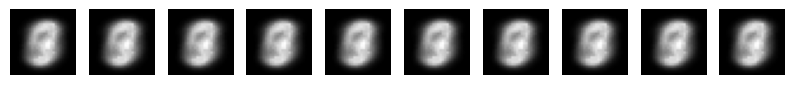

In [25]:
import matplotlib.pyplot as plt

def generate_images(model, num_samples=10, latent_dim=16, device="cuda"):
    model.eval()  
    with torch.no_grad():  
        z = torch.randn(num_samples, latent_dim).to(device)  
        generated_images = model.decoder(z)  
        generated_images = generated_images.cpu().numpy()  

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 1.5))
    for i in range(num_samples):
        axes[i].imshow(generated_images[i, 0], cmap="gray")
        axes[i].axis("off")
    plt.show()

generate_images(vae, num_samples=10, latent_dim=16, device="cuda")